# Parallel Programming - Final Project: Autoencoder for CIFAR-10

Class: 22KHMT

Students: Group 6
| No. | StudentID | Name              |
| :-: | --------- | ----------------- |
|  1  | 22127008  | Đặng Châu Anh     |
|  2  | 22127170  | Trần Dịu Huyền    |
|  3  | 22127359  | Chu Thúy Quỳnh    |

---

## Section 0: Project Setup

First of all, extract the `src.zip` archive to retrieve the required source code for the project and create an `output` directory to store results.

In [ ]:
!unzip -o src.zip
!mkdir -p output

Archive:  src.zip
   creating: src/
   creating: src/phase1/
  inflating: src/phase1/cpu_layers.cpp  
  inflating: src/phase1/autoencoder.cpp  
  inflating: src/phase1/autoencoder.h  
  inflating: src/phase1/train.cpp    
  inflating: src/phase1/cpu_layers.h  
   creating: src/phase2/
  inflating: src/phase2/test.cu      
  inflating: src/phase2/utils.h      
  inflating: src/phase2/extract.cu   
  inflating: src/phase2/gpu_autoencoder.cu  
  inflating: src/phase2/kernels.cuh  
  inflating: src/phase2/data_loader.cpp  
  inflating: src/phase2/train.cu     
  inflating: src/phase2/data_loader.h  
  inflating: src/phase2/gpu_autoencoder.cuh  
  inflating: src/phase2/kernels.cu   
  inflating: src/utils.h             
   creating: src/phase3/
  inflating: src/phase3/gpu_opt.cu   
  inflating: src/phase3/test.cu      
  inflating: src/phase3/train.cpp    
  inflating: src/phase3/weights.bin  
  inflating: src/phase3/extract.cpp  
  inflating: src/phase3/gpu_opt.h    
  inflating: src/data_

---

## Section 1: Problem Description  

### 1.1 Problem Statement

**Definition of the image classification task**  
This project focuses on building an image classification system for the CIFAR-10 dataset using a two-stage pipeline:
1. Unsupervised Feature Learning using a Convolutional Autoencoder
2. Supervised Classification using SVM trained on the learned features

Traditional supervised CNN training requires labeled data and tends to overfit when labels are limited [[2]](#references). In contrast, an autoencoder learns meaningful representations without labels by reconstructing the input images.  
The encoder compresses each 32x32x3 image into an 8,192-dimensional latent vector that captures important visual patterns such as edges, textures, and shapes. These learned features are then used as inputs to an SVM classifier for the final prediction.

**Motivation for GPU acceleration**  
Training a convolutional autoencoder on 50,000 images involves:
- Many 3x3 convolutions
- Millions of multiply-accumulate operations per batch
- Repeated forward/backward passes over many epochs

On a CPU, this process can take hours. The primary objective of the project is to accelerate autoencoder training from hours on CPU to **minutes** on GPU using CUDA, through parallelization and a wide range of GPU optimization strategies.

### 1.2 CIFAR-10 Dataset Overview

**Dataset specifications**
- Image size: 32x32 pixels (RGB)
- 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- Training set: 50,000 images (5,000 per class)
- Test set: 10,000 images (1,000 per class)
- Total images: 60,000
- Format: Binary files with uint8 pixel values

**Sample images visualization**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Download
if not os.path.exists('data/cifar-10-batches-bin'):
    print("Downloading CIFAR-10...")
    !wget -q -P data https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
    !tar -xvf data/cifar-10-binary.tar.gz -C data/
    print("Dataset ready.")

cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin
cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin
cifar-10-batches-bin/data_batch_4.bin
cifar-10-batches-bin/test_batch.bin
cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin
cifar-10-batches-bin/data_batch_2.bin
Dataset ready.


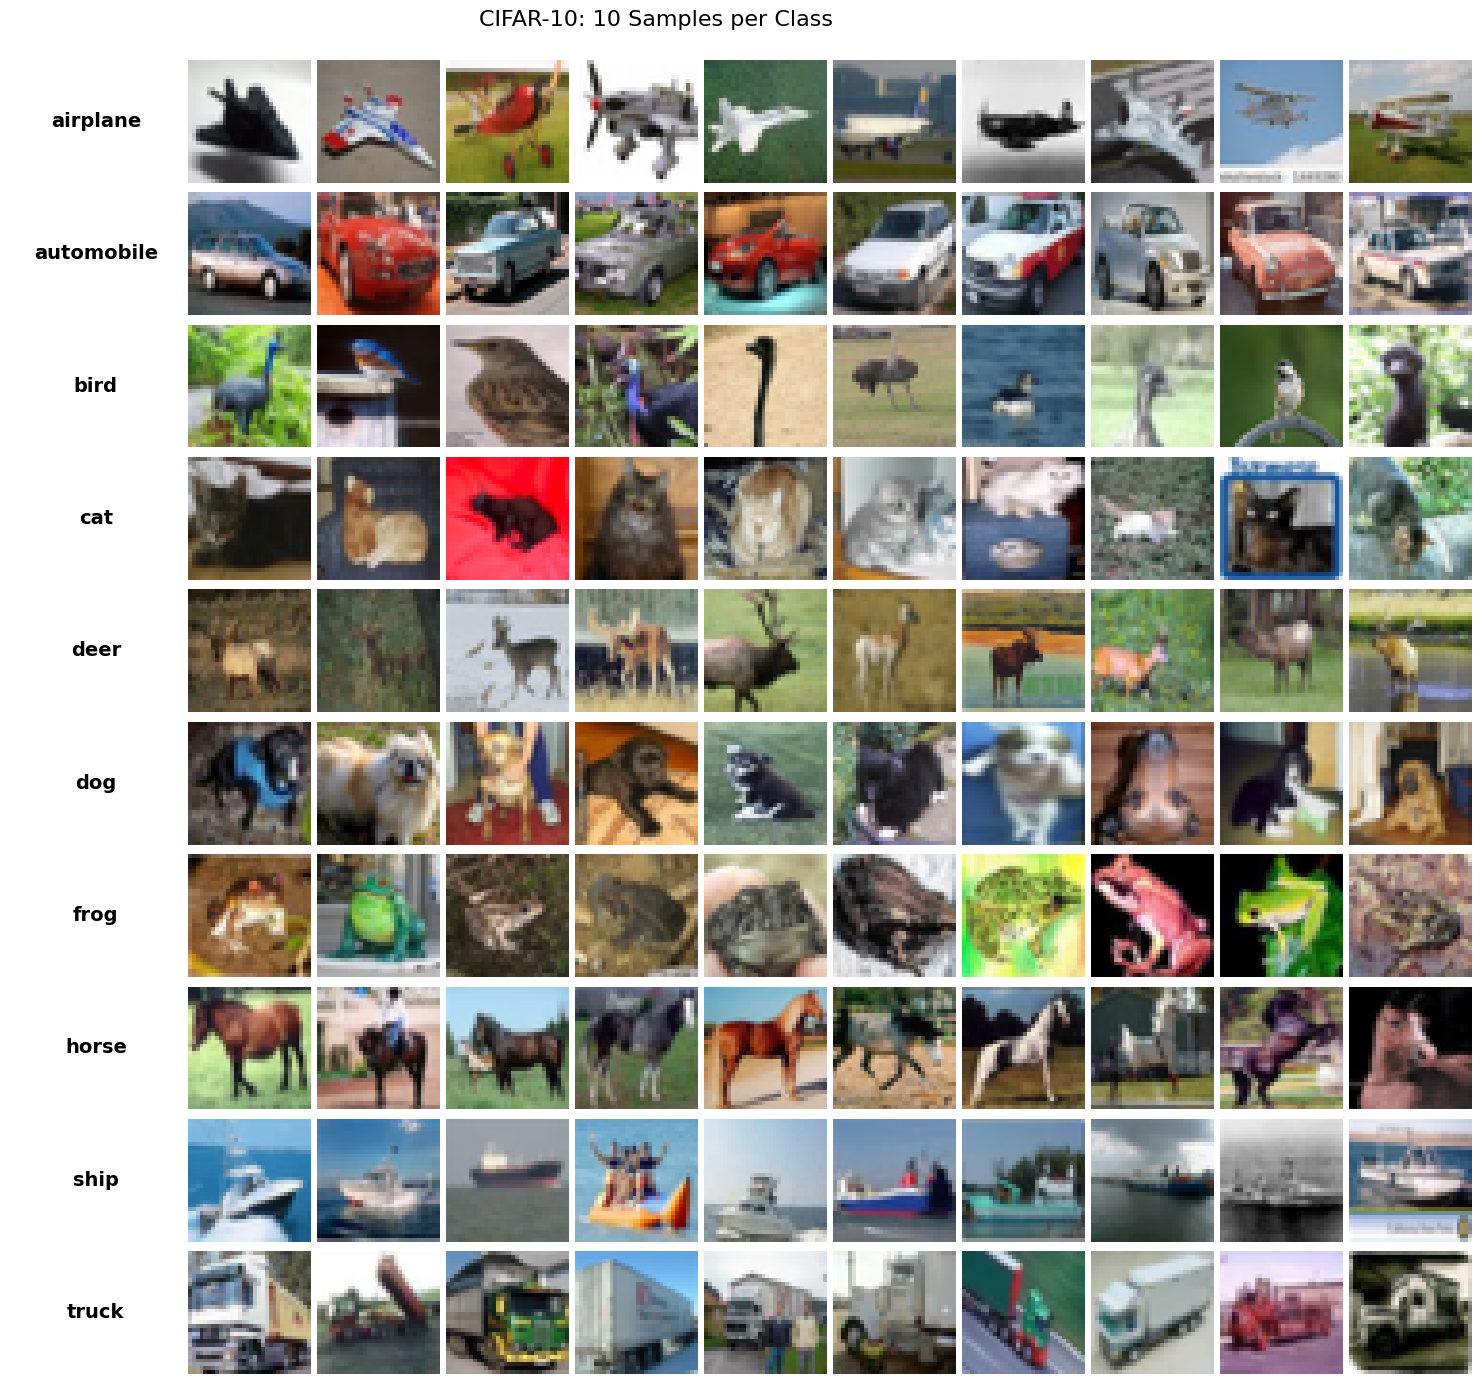

In [ ]:
def show_samples_per_class():
    all_images, all_labels = [], []

    # Load 5 training batches
    for i in range(1, 6):
        path = f"data/cifar-10-batches-bin/data_batch_{i}.bin"
        with open(path, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.uint8)
        raw = data.reshape(-1, 3073)
        labels = raw[:, 0]
        images = raw[:, 1:].reshape(-1, 3, 32, 32).transpose(0,2,3,1)

        all_labels.append(labels)
        all_images.append(images)

    all_labels = np.concatenate(all_labels)
    all_images = np.concatenate(all_images)

    # Collect 10 samples per class
    samples = {c: [] for c in range(10)}
    for img, lbl in zip(all_images, all_labels):
        if len(samples[lbl]) < 10:
            samples[lbl].append(img)
        if all(len(samples[c]) == 10 for c in range(10)):
            break

    # Widen first column
    fig, axes = plt.subplots(
        10, 11,
        figsize=(17, 14),
        gridspec_kw={'width_ratios': [1.4] + [1]*10}
    )

    plt.subplots_adjust(wspace=0.05, hspace=0.06,
                        left=0.12, right=0.98, top=0.96, bottom=0.02)

    for cls in range(10):
        # Label column
        ax_label = axes[cls, 0]
        ax_label.axis("off")
        ax_label.text(
            0.5, 0.5,
            class_names[cls],
            ha='center', va='center',
            fontsize=14, fontweight='bold',
            transform=ax_label.transAxes
        )

        # images
        for j in range(10):
            ax = axes[cls, j+1]
            ax.imshow(samples[cls][j])
            ax.axis("off")

    fig.suptitle("CIFAR-10: 10 Samples per Class", fontsize=16, y=0.995)
    plt.show()


show_samples_per_class()

**Data preprocessing steps**
- Read CIFAR-10 binary files (5 training batches + 1 test batch).
- Parse the binary format: 1 byte label + 3,072 bytes image per record.
- Convert uint8 pixel values [0, 255] to float [0, 1] for normalization.
- Implement batch generation for training.
- Add data shuffling capability.
- Organize train images (50,000), test images (10,000), and their labels in memory.

### 1.3 Autoencoder Architecture

**Network architecture diagram**

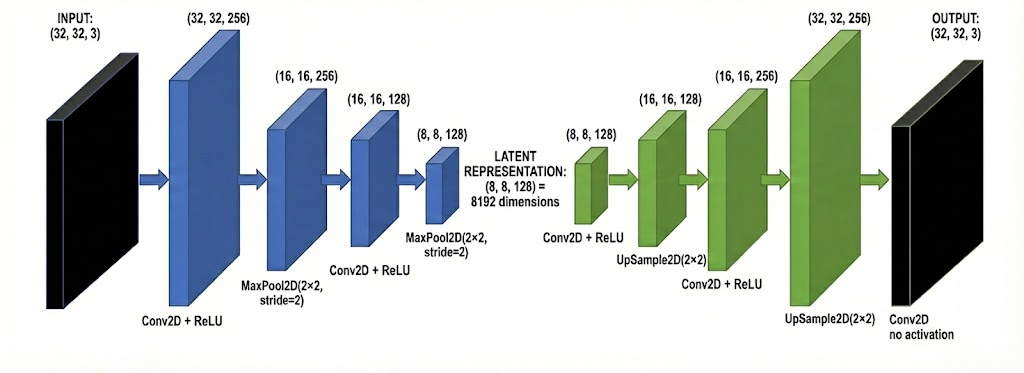

**Layer dimensions and transformations**

| Step | Operation                              |                                                               Params / Details | Output shape                       |
| ---- | -------------------------------------- | -----------------------------------------------------------------------------: | :--------------------------------- |
| 0    | **Input image**                            |                                                                      RGB image | **(32, 32, 3)**                    |
| 1    | Conv2D                                 |                  256 filters, 3x3 kernel, padding=1, stride=1, activation=ReLU | **(32, 32, 256)**                  |
| 2    | MaxPool2D                              |                                                        pool size 2x2, stride=2 | **(16, 16, 256)**                  |
| 3    | Conv2D                                 |                  128 filters, 3x3 kernel, padding=1, stride=1, activation=ReLU | **(16, 16, 128)**                  |
| 4    | MaxPool2D                              |                                                        pool size 2x2, stride=2 | **(8, 8, 128)**                    |
| _    | **Latent representation (bottleneck)** |                                                                              _ | **(8, 8, 128) = 8,192 dimensions** |
| 5    | Conv2D                                 |                  128 filters, 3x3 kernel, padding=1, stride=1, activation=ReLU | **(8, 8, 128)**                    |
| 6    | UpSampling2D                           |                                                scale 2x2 (nearest or bilinear) | **(16, 16, 128)**                  |
| 7    | Conv2D                                 |                  256 filters, 3x3 kernel, padding=1, stride=1, activation=ReLU | **(16, 16, 256)**                  |
| 8    | UpSampling2D                           |                                                                      scale 2x2 | **(32, 32, 256)**                  |
| 9    | Conv2D (output)                        |                      3 filters, 3x3 kernel, padding=1, stride=1, no activation | **(32, 32, 3)**                    |

**Encoder-decoder structure and latent representation analysis**

Encoder
- The encoder applies two stages of `Conv2D -> ReLU -> MaxPool`.
- The first convolution expands the channel dimension from $3 \to 256$ while preserving spatial resolution (3x3, padding=1). `MaxPool` then halves spatial dimensions ($32 \to 16$).
- The second stage reduces channels to 128 while further halving spatial size to $8 \times 8$.
- The encoder therefore compresses both spatial and channel information, producing a dense feature tensor (8, 8, 128) which is the latent representation.

Latent representation
- The tensor (8x8x128) is the information the encoder preserves for reconstruction/classification.
- Flattening would give 8192 values, but this design keeps the latent as a 3D tensor so the network remains fully convolutional (no fully-connected flattening required).
- The latent space encodes spatially local features and higher-level patterns useful for downstream tasks (here: SVM classification on extracted features).

Decoder
- The decoder mirrors the encoder: it first applies a `Conv2D` on the latent tensor (128 filters), then upsamples ($\times 2$) to restore spatial size, increases channels (to 256) with another convolution, upsamples again ($\times 2$), and finally projects back to 3 channels for RGB reconstruction.
- The final `Conv2D` uses no activation (identity) so the network can produce raw pixel values.

### 1.4 Project Objectives

**Performance goals**
| Metric                    | Target                              |
| ------------------------- | ----------------------------------- |
| Autoencoder training time | < 10 minutes                        |
| Feature extraction time   | < 20 seconds (for all 60,000 images)|
| Test accuracy (SVM)       | 60-65%                              |
| GPU speedup over CPU      | >20x                                |


**Technical learning objectives**
- Implementing a convolutional autoencoder on CPU.
- Implementing and optimizing GPU kernels using CUDA.
- Managing GPU memory efficiently (global, shared, constant memory).
- Applying optimization strategies such as tiling, kernel fusion, vectorization.
- Using SVM (`ThunderSVM`) for classification.
- Profiling and performance analysis (`nvprof`, `ncu`).

**Success criteria**
- The autoencoder reconstructs CIFAR-10 images with recognizable features and low error.
- GPU training is at least 20x faster than CPU baseline.
- Feature extraction produces correct 8,192-dimensional vectors.
- SVM achieves $\geq 60\%$ accuracy on CIFAR-10 test set.
- The final report includes full analysis, visualizations, and performance metrics.

---

## Section 2: Implementation Phases

### Phase 2.1: CPU Baseline Implementation  
This phase focused on building a functional Autoencoder and SVM classifier using pure C++ to establish a correctness benchmark and a performance baseline.

**1. Objectives**
- To create a reference implementation: the output of this CPU version serves as the ground truth to verify the accuracy of the CUDA kernels in later phases.
- To measure the execution time of the unoptimized sequential algorithm, allowing for the calculation of exact speedup metrics when moving to GPU.
- To deeply understand the computational complexity of Convolutional Neural Network (CNN) layers, specifically the nested loops involved in convolution and pooling.

**2. Implementation Details**

- **Data Pipeline**
    - Loading: Implemented reader using `ifstream` to parse the CIFAR-10 binary files (5 training batches, 1 test batch) directly into memory.
    - Preprocessing:
        - Reshaped raw 1D arrays into (Channel, Height, Width) format.
        - Normalized pixel values from $[0, 255]$ to $[0.0, 1.0]$ (floating point) to stabilize training.
        - Created a custom `Tensor` structure to manage multi-dimensional data explicitly.
    - Shuffling: Implemented a Fisher-Yates style shuffle using `mt19937` to randomize the training vector before training to ensure statistical independence of batches.

- **Layer Implementation**
    - Conv2D: Implemented using nested loops to iterate over the `vector<Tensor>` batch. Since data is not contiguous in memory across the batch (fragmented `Tensor` objects), the loop iterates image-by-image.
    - ReLU: Simple element-wise activation: $f(x) = \max(0, x)$.
    - MaxPool: Downsampling by selecting the maximum value within $2\times2$ windows.
    - Upsample: Nearest-neighbor interpolation to restore spatial dimensions.

- **Training Loop** (Standard SGD loop)
    - Mini-batching: Iterated through the vector<Tensor> in chunks (32 images). Inside each batch, images are processed sequentially (one-by-one).
    - Forward: Computed activations sequentially through the Autoencoder architecture: Encoder (`Conv -> ReLU -> MaxPool`) compressing data, followed by Decoder (`Conv -> ReLU -> UpSample`) reconstructing it.
    - Loss Calculation: Implemented Mean Squared Error (MSE) between the input tensor and the output tensor for each image: $L = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$, where $N$ is the total number of pixels.
    - Backward Pass: Calculated gradients layer-by-layer using Backpropagation. Gradients for each image in the batch are accumulated into `accum_grad_w` and `accum_grad_b` buffers within each layer instead of updating weights immediately.
    - Weight Update: Updated global weights after processing entire mini-batch.

- **Key Code Snippets**
    - Convolution class signature: Defining the core layer structure. Note the inclusion of `accum_grad` buffers, which are essential for implementing mini-batch gradient descent on CPU by accumulating gradients across sequential image processing.

    ```cpp
    // src/phase1/cpu_layers.h
    class Conv2D {
    public:
        int in_c, out_c, k_size, stride, pad;
        vector<float> weights, biases;
        vector<float> accum_grad_w;
        vector<float> accum_grad_b;
        
        const Tensor* input_cache_ptr;
        Conv2D(int in, int out, int k=3, int s=1, int p=1);
        void init_weights();
        Tensor forward(const Tensor& input);
        Tensor backward(const Tensor& grad_out);
        void update_weights(float lr);
    };
    ```

    - The performance bottleneck (Naive Convolution): The implementation of the forward pass involves 6 nested loops, resulting in $O(N^4)$ computational complexity. This specific function is identified as the primary bottleneck requiring GPU acceleration.

    ```cpp
    // src/phase1/cpu_layers.cpp
    Tensor Conv2D::forward(const Tensor& input) {
        for (int oc = 0; oc < out_c; ++oc) {            // Loop 1: Output Channels
            for (int oy = 0; oy < out_h; ++oy) {        // Loop 2: Output Height
                for (int ox = 0; ox < out_w; ++ox) {    // Loop 3: Output Width
                    float sum = biases[oc];
                    
                    for (int ic = 0; ic < in_c; ++ic) { // Loop 4: Input Channels
                        for (int ky = 0; ky < k_size; ++ky) {     // Loop 5: Kernel Y
                            for (int kx = 0; kx < k_size; ++kx) { // Loop 6: Kernel X
                                sum += inData[in_idx] * weights[w_idx];
                            }
                        }
                    }
                    outData[out_idx] = sum;
                }
            }
        }
        return output;
    }
    ```

    - Training loop with gradient accumulation: Since the CPU implementation handles images sequentially (one-by-one) rather than in parallel batches, gradients are calculated and accumulated for each image, then weights are updated once per batch.

    ```cpp
    // src/phase1/train.cpp
    // ... Inside the batch loop ...
    for (int idx = start; idx < end; ++idx) {
        const Tensor& img = dataset.train_images[idx];

        // 1. Forward
        Tensor output = model.forward(img);

        // 2. Loss
        float loss = mse_loss(output, img);
        batch_loss += loss;

        // 3. Backward
        Tensor grad = mse_loss_grad(output, img);
        model.backward(grad);
    }

    // 4. Weight update (once per batch)
    float effective_lr = LR / (float)current_batch_size;
    model.update(effective_lr);
    ```

**3. Execution & Results**

- **Execution**

Due to the significant computational cost of the naive CPU implementation ($O(N^4)$ complexity), the training dataset was subsampled to **10,000 images** (Batch 1 only, approx. 20% of CIFAR-10) instead of the full 50,000. This reduction allows for a feasible turnaround time to verify algorithmic correctness and convergence behavior without excessive waiting.

The C++ source code was compiled with `-O3` optimization to minimize overhead before execution.

In [ ]:
!g++ -O3 -I./src src/phase1/*.cpp src/*.cpp -o run_phase1

In [ ]:
!./run_phase1

--- Phase 1: CPU Baseline ---
[Data] Loaded 10000 train, 10000 test images.
Training Settings:
- Batch Size: 32
- Epochs: 20
- Learning Rate: 0.001

[Start Training]...
Epoch 1/20 [Batch 310/313] Loss: 0.03893
Epoch 1 Done. Avg Loss: 0.06081 | Time: 7922.67383s | Mem: 255 MB
Epoch 2/20 [Batch 310/313] Loss: 0.02558
Epoch 2 Done. Avg Loss: 0.03359 | Time: 7747.92383s | Mem: 255 MB
Epoch 3/20 [Batch 310/313] Loss: 0.02452
Epoch 3 Done. Avg Loss: 0.02783 | Time: 7794.39990s | Mem: 255 MB
Epoch 4/20 [Batch 310/313] Loss: 0.02042
Epoch 4 Done. Avg Loss: 0.02488 | Time: 7829.91650s | Mem: 255 MB
Epoch 5/20 [Batch 310/313] Loss: 0.02115
Epoch 5 Done. Avg Loss: 0.02297 | Time: 7756.98535s | Mem: 255 MB
Epoch 6/20 [Batch 310/313] Loss: 0.02041
Epoch 6 Done. Avg Loss: 0.02157 | Time: 7836.60205s | Mem: 255 MB
Epoch 7/20 [Batch 310/313] Loss: 0.02297
Epoch 7 Done. Avg Loss: 0.02048 | Time: 7954.17920s | Mem: 255 MB
Epoch 8/20 [Batch 310/313] Loss: 0.01985
Epoch 8 Done. Avg Loss: 0.01960 | Time: 7

- **Results**

The table below summarizes the performance on the reduced dataset (10,000 images) over 20 epochs.

| Metric | Value |
| :--- | :--- |
| Training time (per epoch) | ~7,873s |
| Total training time | ~157,469s (\~787,348s on 50,000 images) |
| Final training loss | 0.01482 |
| Memory usage | 255 MB |

- **Sample reconstruct images**

To verify visual correctness, we load the binary output from `output/cpu_reconstruction.bin` and compare the original input with the reconstructed output.

Loading visualization data from output/cpu_reconstruction.bin...


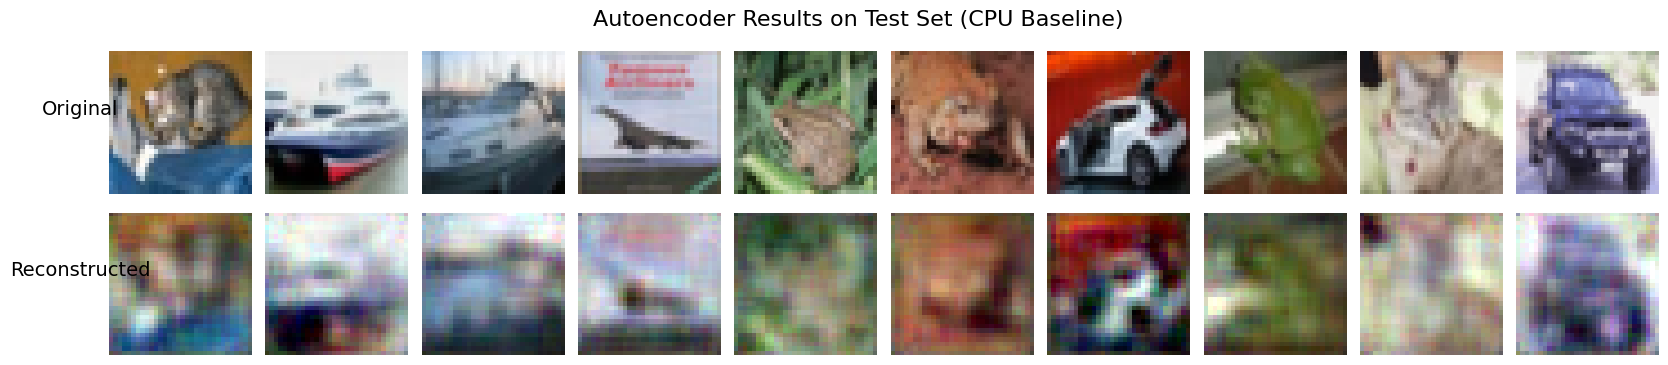

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_results(filename="output/cpu_reconstruction.bin"):
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return

    print(f"Loading visualization data from {filename}...")

    with open(filename, "rb") as f:
        # Read header (4 bytes: number of samples)
        try:
            header = f.read(4)
            if not header:
                print("Empty file.")
                return
            num_samples = struct.unpack('i', header)[0]
        except Exception as e:
            print(f"Error reading header: {e}")
            return

        fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)

        for i in range(num_samples):
            # Read original image
            raw_orig = f.read(3072 * 4)
            if not raw_orig: break
            img_orig = np.array(struct.unpack('f' * 3072, raw_orig)).reshape(3, 32, 32).transpose(1, 2, 0)

            # Read reconstructed image
            raw_recon = f.read(3072 * 4)
            if not raw_recon: break
            img_recon = np.array(struct.unpack('f' * 3072, raw_recon)).reshape(3, 32, 32).transpose(1, 2, 0)

            # Show original image
            axes[0, i].imshow(np.clip(img_orig, 0, 1))
            axes[0, i].axis("off")
            if i == 0:
                axes[0, i].set_title("Original", fontsize=14, x=-0.2, y=0.5)

            # Show reconstructed image
            axes[1, i].imshow(np.clip(img_recon, 0, 1))
            axes[1, i].axis("off")
            if i == 0:
                axes[1, i].set_title("Reconstructed", fontsize=14, x=-0.2, y=0.5)

        plt.suptitle("Autoencoder Results on Test Set (CPU Baseline)", fontsize=16)
        plt.show()

visualize_results()

From the performance metrics and the visual reconstruction results, we can draw several conclusions regarding the CPU Baseline implementation:
- Computational Bottleneck: The prohibitive training time (~43.7 hours total, ~2.2 hours/epoch) validates the $O(N^4)$ complexity of the nested loops, confirming the critical need for GPU parallelization.
- Visual Quality: The model successfully captures global structures and colors, validating the data pipeline. However, images exhibit blurriness and checkerboard artifacts, which are expected characteristics of MSE loss and simple Nearest Neighbor upsampling.
- Convergence: A steady loss decrease to 0.01482 confirms the mathematical correctness of the backpropagation and gradient accumulation logic.
- Resource Usage: Stable memory usage (255 MB) indicates the system is compute-bound, not memory-bound.

**4. Key Takeaways**
- Surprisingly Slow: Processing even a small subset (20%) of CIFAR-10 took nearly 2 days. This practical observation reinforces the theoretical analysis that general-purpose CPUs are ill-suited for deep learning training.
- Optimization Opportunities:
  - Pixel Independence: The analysis of the nested loops reveals that each output pixel $(oc, oy, ox)$ is calculated independently. This is the primary candidate for mapping to GPU threads.
  - Data Reuse: The sliding window nature of convolution means input pixels are read multiple times. On the GPU, this access pattern must be optimized using Shared Memory to avoid the latency penalties observed here.

### Phase 2.2: GPU Basic Implementation  
This phase involved porting the CPU baseline to the GPU using CUDA. The focus was on correctness and establishing a preliminary parallel structure without advanced optimizations (like Shared Memory or Tiling).

**1. Objectives**
- Translate the C++ sequential logic into CUDA C++ kernels (`__global__` functions).
- Ensure the GPU output matches the CPU reference within a floating-point tolerance.
- Establish the initial speedup metric to identify bottlenecks for future optimization.

**2. Implementation Details**

- **Parallelization Strategy**
    - Mapping: Adopted a "One Thread Per Output Pixel" strategy using 1D indexing. The linear global index idx is remapped to 3D coordinates (Channel, Height, Width) inside the kernel.
    - Batch Processing: Unlike the CPU implementation which looped purely sequentially, the GPU implementation processes the batch via a **Host-side Loop**. For each sample, data is copied to the GPU, processed, and gradients are accumulated using `atomicAdd` directly in device memory.

- **Kernel Designs**
    - Convolution kernel:
        - Each thread calculates one output pixel (oc, h, w).
        - The thread iterates over Input Channels and the Kernel Window ($K \times K$) to perform the dot product.
    - Memory Access: Direct reads from Global Memory.
    - Pooling kernel:
        - Threads map to output pixels (H/2, W/2).
        - Each thread reads 4 specific values (2x2 block) from the input, finds the maximum, and stores the index for the unpooling step.
    - Other kernels:
        - ReLU: Simple element-wise operation mapped linearly (N threads for $N$ elements).
        - Upsample: Nearest-neighbor scaling where each thread copies one input pixel to a 2x2 output block (or vice-versa in backward pass).

- **Memory Management**
    - Allocation: Utilized `cudaMalloc` to allocate memory for all weights, activations, and gradient buffers once during initialization to avoid allocation overhead during the training loop.
    - Data Flow: Implemented `cudaMemcpy` within the training loop to transfer inputs sample-by-sample from Host to Device, while keeping weights and intermediate states resident on the GPU.

- **Key Code Snippets**
    - Basic Convolution Kernel Signature (1D Flattened Mapping):

    ```cpp
    // phase2/kernels.cu
    __global__ void conv2d_forward_naive_kernel(const float* __restrict__ input,
                                                const float* __restrict__ weights,
                                                const float* __restrict__ bias,
                                                float* __restrict__ output,
                                                int inC, int inH, int inW, int outC, int k)
    {
        // Calculate linear index
        int idx = blockIdx.x * blockDim.x + threadIdx.x;
        int total = outC * outH * outW;
        if (idx >= total) return;

        // Map back to 3D coordinates
        int w = idx % outW;
        int tmp = idx / outW;
        int h = tmp % outH;
        int oc = tmp / outH;

        float sum = 0.0f;
        int pad = k/2;
        // Naive loops over input channels and kernel window
        for (int ic = 0; ic < inC; ++ic) {
            // ... Inner loops (kh, kw) reading from global memory ...
            sum += val * weights[widx];
        }
        if (bias) sum += bias[oc];
        output[idx] = sum;
    }
    ```

    - Launch Configuration (1D Grid):

    ```cpp
    // phase2/kernels.cu (Wrapper)
    void launch_conv2d_forward_naive(...) {
        int total = outC * inH * inW;
        int block = 256;
        int grid = (total + block - 1) / block;
        conv2d_forward_naive_kernel<<<grid, block>>>(...);
    }
    ```

**3. Execution & Results**

- **Execution**

In [ ]:
!nvcc -O2 -arch=sm_75 src/phase2/train.cu src/phase2/gpu_autoencoder.cu src/phase2/kernels.cu src/phase2/data_loader.cpp -o run_phase2

In [ ]:
!./run_phase2

[Config] cifar_dir='./data/cifar-10-batches-bin' epochs=20 batch_size=64 lr_init=0.001000
[Data] Loaded 50000 train, 10000 test images.
[GPUAutoencoder] Initialized weights and allocated device memory.
--- Memory after Model Init ---
[GPU Mem] Used: 114.94 MB | Free: 14980.12 MB | Total: 15095.06 MB
[Train] Starting loop. Total steps: 782 per epoch.

Epoch 01/20 | Step 100/782 | BS: 64 | Loss: 0.054933 | LR: 0.001000 | Mem: 115 MB
Epoch 01/20 | Step 200/782 | BS: 64 | Loss: 0.045966 | LR: 0.001000 | Mem: 115 MB
Epoch 01/20 | Step 300/782 | BS: 64 | Loss: 0.037753 | LR: 0.001000 | Mem: 115 MB
Epoch 01/20 | Step 400/782 | BS: 64 | Loss: 0.034745 | LR: 0.001000 | Mem: 115 MB
Epoch 01/20 | Step 500/782 | BS: 64 | Loss: 0.034629 | LR: 0.001000 | Mem: 115 MB
Epoch 01/20 | Step 600/782 | BS: 64 | Loss: 0.032250 | LR: 0.001000 | Mem: 115 MB
Epoch 01/20 | Step 700/782 | BS: 64 | Loss: 0.026292 | LR: 0.001000 | Mem: 115 MB
Epoch 01/20 | Step 782/782 | BS: 16 | Loss: 0.022772 | LR: 0.001000 | Mem

- **Results**

| Metric | Value |
| :--- | :--- |
| Training time (per epoch) | 175s
| Total training time | 4343.70s (On 50,000 images)
| Final training loss | 0.011412
| GPU Memory usage | 115 MB |
| **Speedup (vs CPU)** | **181.0x** |

- **Sample reconstruct images**


In [ ]:
!nvcc -O2 -arch=sm_75 src/phase2/test.cu src/phase2/gpu_autoencoder.cu src/phase2/kernels.cu src/phase2/data_loader.cpp -o run_phase2_test

In [ ]:
!./run_phase2_test

[Data] Loaded 50000 train, 10000 test images.
[GPUAutoencoder] Initialized weights and allocated device memory.
Loading weights from 'output/gpu_basic_model.bin'...
[GPUAutoencoder] Loaded weights from 'output/gpu_basic_model.bin'
[Test] Running inference on 10 images...
[Report] Saved binary results to 'output/gpu_basic_reconstruction.bin'


Loading visualization data from output/gpu_basic_reconstruction.bin...


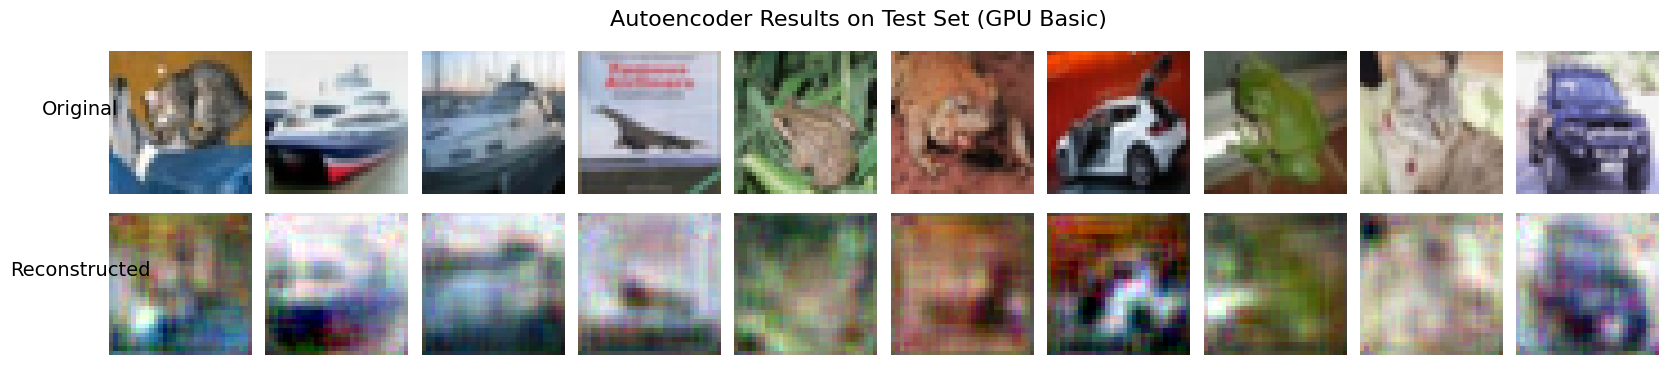

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_results(filename="output/gpu_basic_reconstruction.bin"):
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return

    print(f"Loading visualization data from {filename}...")

    with open(filename, "rb") as f:
        # Read header (4 bytes: number of samples)
        try:
            header = f.read(4)
            if not header:
                print("Empty file.")
                return
            num_samples = struct.unpack('i', header)[0]
        except Exception as e:
            print(f"Error reading header: {e}")
            return

        fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)

        for i in range(num_samples):
            # Read original image
            raw_orig = f.read(3072 * 4)
            if not raw_orig: break
            img_orig = np.array(struct.unpack('f' * 3072, raw_orig)).reshape(3, 32, 32).transpose(1, 2, 0)

            # Read reconstructed image
            raw_recon = f.read(3072 * 4)
            if not raw_recon: break
            img_recon = np.array(struct.unpack('f' * 3072, raw_recon)).reshape(3, 32, 32).transpose(1, 2, 0)

            # Show original image
            axes[0, i].imshow(np.clip(img_orig, 0, 1))
            axes[0, i].axis("off")
            if i == 0:
                axes[0, i].set_title("Original", fontsize=14, x=-0.2, y=0.5)

            # Show reconstructed image
            axes[1, i].imshow(np.clip(img_recon, 0, 1))
            axes[1, i].axis("off")
            if i == 0:
                axes[1, i].set_title("Reconstructed", fontsize=14, x=-0.2, y=0.5)

        plt.suptitle("Autoencoder Results on Test Set (GPU Basic)", fontsize=16)
        plt.show()

visualize_results()

**4. Profiling Analysis**


- Basic profiling results:
    - Convolution kernels: Account for the vast majority of GPU execution time due to heavy arithmetic and memory access.
    - Memcpy: Significant latency is incurred in `HtoD` transfers because the data transfer is strictly synchronized for every single image inside the host loop `for (int b = 0; b < cur_bs; ++b)` in training process.

- Memory bandwidth utilization: The basic convolution kernel suffers from poor "Compute-to-Global-Memory-Access" ratio. Input pixels are re-read from DRAM multiple times by neighboring threads.

- Initial bottleneck identification:
    - Global memory latency: The primary bottleneck is the uncoalesced and redundant access to Global Memory in the convolution kernels.
    - Launch overhead: Launching kernels per-sample (Batch Size $\times$ Layers) introduces CPU-GPU synchronization overhead.

**5. Key Takeaways**
- Surprisingly Fast: Even without Shared Memory, the massive parallelism of the GPU (thousands of threads) provided a substantial speedup over the sequential CPU loops.
- Optimization Opportunities:
    - Tiling: Implementing Shared Memory tiling for Convolution is critical to reduce redundant global memory reads.
    - Batch kernels: Modifying kernels to handle the entire batch $(N, C, H, W)$ in a single launch would eliminate the host-side loop and reduce cudaMemcpy overhead.

### Phase 2.3: GPU Optimized Implementation
This phase focused on optimizing the Basic GPU implementation by leveraging Shared Memory Tiling to minimize redundant global memory accesses and maximize data reuse for higher execution throughput.

**0. Optimization Focus** (Memory Optimization)

**1. Objectives**

- **Targeted Optimizations**: Implementing Shared Memory Tiling for convolutions, Kernel Fusion for activations, and Asynchronous Data Transfer using CUDA Streams.

- **Expected Performance Improvement**: Significant reduction in Global Memory traffic and hiding H2D (Host-to-Device) latency, leading to faster per-epoch training times.

**2. Implementation Details**

- **Optimization Technique(s) Applied**
    
    - Shared Memory Tiling:
      
      - Explanation:
      
        Data tiles and their surrounding "halo" pixels are loaded into the block's shared memory before performing the $3 \times 3$ convolution.
      
      - Why it helps:
      
        In a $3 \times 3$ convolution, each input pixel is read up to 9 times from Global Memory; shared memory reduces this to a single Global Memory read per pixel for the entire block.
        
      - Approach:
        
        Threads in a block collaboratively load a `(TILE_H + 2) * (TILE_W + 2)` region into a shared array before computation.
        
    - Kernel Fusion:
    
      - Explanation:
      
        The bias addition and ReLU activation are performed within the convolution kernel rather than in separate kernel launches.
        
      - Why it helps:
      
        It eliminates the need to write the intermediate convolution output to Global Memory and read it back for the activation step.
        
      - Approach:
      
        The `acc += b[oc]` and `if (acc < 0.f) acc = 0.f` logic is appended to the end of the conv3x3_bias_relu_fwd_opt kernel.
      
    - Asynchronous Double Buffering:
      
        - Explanation:
        
          Utilizing two CUDA streams to overlap the data transfer of the next batch with the computation of the current batch.
        
        - Why it helps:
        
          It effectively "hides" the PCIe transfer time, preventing the GPU from idling while waiting for new data.
        
        - Approach:
        
          Used cudaMemcpyAsync with pinned memory and cudaStreamWaitEvent to synchronize the H2D and Compute streams.

**3. Execution & Results**

- **Execution**

In [ ]:
!nvcc -O2 -arch=sm_75 src/phase3/train.cpp src/data_loader.cpp src/phase3/gpu_opt.cu -o run_phase3

In [ ]:
!./run_phase3

[Data] Loaded 50000 train, 10000 test images.
[Data] Loaded 50000 train images.
[Config] epochs=20, batch_size=128, lr=0.005000
[Memory] GPU Usage: 838.94 MB / 15095.06 MB
-------------------------------------------------
[Train] Starting training...
Ep 01/20 | Step 390/390 | Loss: 0.05038 | Epoch Time: 100.192s
Ep 02/20 | Step 390/390 | Loss: 0.02376 | Epoch Time: 107.317s
Ep 03/20 | Step 390/390 | Loss: 0.02203 | Epoch Time: 107.816s
Ep 04/20 | Step 390/390 | Loss: 0.02156 | Epoch Time: 107.848s
Ep 05/20 | Step 390/390 | Loss: 0.02077 | Epoch Time: 107.787s
Ep 06/20 | Step 390/390 | Loss: 0.02057 | Epoch Time: 107.732s
Ep 07/20 | Step 390/390 | Loss: 0.02030 | Epoch Time: 107.720s
Ep 08/20 | Step 390/390 | Loss: 0.02012 | Epoch Time: 107.672s
Ep 09/20 | Step 390/390 | Loss: 0.01976 | Epoch Time: 107.813s
Ep 10/20 | Step 390/390 | Loss: 0.01940 | Epoch Time: 107.671s
Ep 11/20 | Step 390/390 | Loss: 0.01982 | Epoch Time: 107.678s
Ep 12/20 | Step 390/390 | Loss: 0.01932 | Epoch Time: 10

- **Results**  

| Metric | Value |
| :--- | :--- |
| Training time (per epoch) | 107s |
| Total training time | 1285s |
| Final training loss | 0.01932 |
| Memory usage | 841 MB |

- **Sample reconstruct images**

In [ ]:
!nvcc -O2 -arch=sm_75 src/phase3/test.cu src/data_loader.cpp src/phase3/gpu_opt.cu -o run_test_phase3

In [ ]:
!./run_test_phase3

[Data] Loaded 50000 train, 10000 test images.
[System] Loading weights from output/gpu_opt_model.bin...
[System] Weights successfully loaded from: output/gpu_opt_model.bin
[Test] Preparing batch for 10 samples...
[Test] Forwarding through GPU using forward_only...
[Success] Saved 10 reconstructed samples to 'output/gpu_opt_reconstruction.bin'.


Loading visualization data from output/gpu_opt_reconstruction.bin...


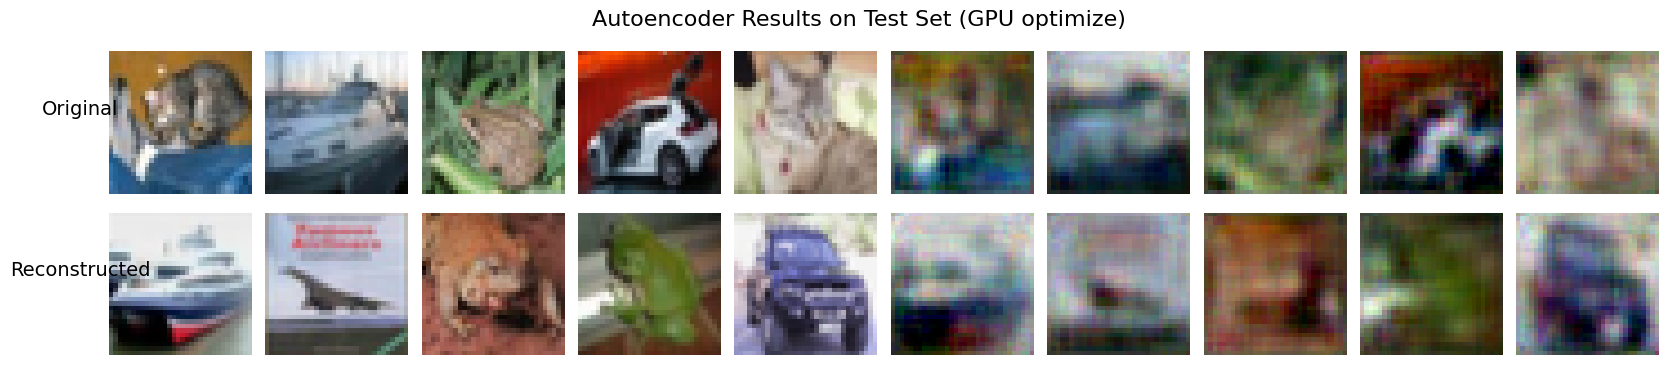

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_results(filename="output/gpu_opt_reconstruction.bin"):
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return

    print(f"Loading visualization data from {filename}...")

    with open(filename, "rb") as f:
        # Read header (4 bytes: number of samples)
        try:
            header = f.read(4)
            if not header:
                print("Empty file.")
                return
            num_samples = struct.unpack('i', header)[0]
        except Exception as e:
            print(f"Error reading header: {e}")
            return

        fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)

        for i in range(num_samples):
            # Read original image
            raw_orig = f.read(3072 * 4)
            if not raw_orig: break
            img_orig = np.array(struct.unpack('f' * 3072, raw_orig)).reshape(3, 32, 32).transpose(1, 2, 0)

            # Read reconstructed image
            raw_recon = f.read(3072 * 4)
            if not raw_recon: break
            img_recon = np.array(struct.unpack('f' * 3072, raw_recon)).reshape(3, 32, 32).transpose(1, 2, 0)

            # Show original image
            axes[0, i].imshow(np.clip(img_orig, 0, 1))
            axes[0, i].axis("off")
            if i == 0:
                axes[0, i].set_title("Original", fontsize=14, x=-0.2, y=0.5)

            # Show reconstructed image
            axes[1, i].imshow(np.clip(img_recon, 0, 1))
            axes[1, i].axis("off")
            if i == 0:
                axes[1, i].set_title("Reconstructed", fontsize=14, x=-0.2, y=0.5)

        plt.suptitle("Autoencoder Results on Test Set (GPU optimize)", fontsize=16)
        plt.show()

visualize_results()

**4. Profiling Analysis**

In [ ]:
!nvprof ./run_phase3

[Data] Loaded 50000 train, 10000 test images.
[Data] Loaded 50000 train images.
==8996== NVPROF is profiling process 8996, command: ./run_phase3
[Config] epochs=20, batch_size=128, lr=0.005000
[Memory] GPU Usage: 850.94 MB / 15095.06 MB
-------------------------------------------------
[Train] Starting training...
Ep 01/20 | Step 390/390 | Loss: 0.04993 | Epoch Time: 106.685s
Ep 02/20 | Step 390/390 | Loss: 0.02548 | Epoch Time: 106.544s
Ep 03/20 | Step 390/390 | Loss: 0.02424 | Epoch Time: 106.527s
Ep 04/20 | Step 390/390 | Loss: 0.02338 | Epoch Time: 106.531s
Ep 05/20 | Step 390/390 | Loss: 0.02261 | Epoch Time: 106.544s
Ep 06/20 | Step 390/390 | Loss: 0.02223 | Epoch Time: 106.549s
Ep 07/20 | Step 390/390 | Loss: 0.02201 | Epoch Time: 106.550s
Ep 08/20 | Step 390/390 | Loss: 0.02146 | Epoch Time: 106.531s
Ep 09/20 | Step 390/390 | Loss: 0.02040 | Epoch Time: 106.540s
Ep 10/20 | Step 390/390 | Loss: 0.02157 | Epoch Time: 106.530s
Ep 11/20 | Step 390/390 | Loss: 0.01951 | Epoch Time: 

- Basic profiling results:
  - Convolution dominance: Convolution operations continue to monopolize GPU resources, aggregating to over **97%** of total active time (`fwd_opt`, `dx_naive`, `dwdb_tiled`).
  - Kernel breakdown:** The workload is split between the optimized forward/weight-update kernels (\~61.6%) and the remaining unoptimized backward-data kernel (\~34.0%).

- Optimization impact:
  - Shared memory tiling: The implementation of `_opt` and `_tiled` kernels successfully mitigated the "Memory Wall" for the forward pass and weight gradient calculation. The Data-to-L1-Cache reuse strategy significantly reduced the Global Memory traffic for these specific operations.

- Current bottleneck identification:
  - The "Naive" residual: The primary bottleneck is now strictly identified as the `conv3x3_dx_naive` kernel (calculating input gradients). It alone accounts for **\~34%** of runtime because it still relies on redundant Global Memory accesses without Tiling optimization.
  - Optimization target: To achieve a fully optimized pipeline, the next optimization phase must apply Tiling techniques to this specific backward-pass kernel.

**5. Key Takeaways**
- Lessons learned from this optimization:
  - Memory Wall reality: The significant speedup (**3.4x** vs Basic) confirmed that data movement, not compute, was the primary limitation. Reducing global memory traffic via Shared Memory is the single most effective optimization for convolution.
  - Bottleneck shifting: Profiling revealed a "Whack-a-Mole" effect: once the forward kernels were optimized, the remaining unoptimized backward kernel (`conv3x3_dx_naive`) immediately became the dominant bottleneck (consuming **~34%** of execution time).

- Applicability to other problems:
  - Stencil operations: The "Sliding Window" tiling technique implemented here is directly applicable to various image processing tasks (Gaussian blur, Sobel edge detection) and scientific simulations (finite difference methods).
  - Matrix math: The core concept of cooperative block loading into L1 Cache (Shared Memory) is the foundational principle for optimizing any bandwidth-heavy algorithm, such as General Matrix Multiplication (GEMM).

### Phase 2.5: SVM Integration
This phase involves developing an SVM classifier using cuML to establish a benchmark for both functional correctness and execution performance.

**1. Objectives**
- Extract features using trained encoder
- Train SVM classifier on learned features
- Evaluate end-to-end classification performance


**2. Implementation Details**

- **Feature Extraction**  
The extraction follows a feed-forward path through the encoder layers to generate a latent representation (features):  
Layer Sequence:
  - Conv1 + ReLU: Initial feature detection.
  - MaxPool (2x2): Downsampling from $32 \times 32$ to $16 \times 16$.
  - Conv2 + ReLU: Deep feature extraction.
  - MaxPool (2x2): Final downsampling to $8 \times 8$, resulting in a latent vector of $128 \times 8 \times 8 = 8192$ dimensions.

- **LIBSVM Integration**
  - **Binary Data Ingestion**  
  The interface utilizes direct binary mapping to transfer the 8,192-dimensional latent vectors from the C++ output to the Python environment:
    - NumPy Integration: The data is loaded using `np.fromfile`, which maps the raw binary blobs directly into structured arrays.
    - Zero-copy Compatibility: By maintaining a contiguous `float32` format in C++, the data is immediately ready for GPU offloading without requiring complex parsing or reformatting.

  - **GPU Memory Management (CuPy Integration)**  
  To leverage the full power of the NVIDIA RAPIDS ecosystem, the system transitions data from the CPU host to GPU device memory using CuPy:
    -  `cp.array()`: Transfers the feature matrix (50,000 × 8192) to the GPU.


- **Hyperparameter Selection**  
  - Kernel: Radial Basis Function (RBF).
  - Gamma: Set to auto ($\frac{1}{8192}$), specifically tuned for the high-dimensional feature output of the Encoder.
  - C Parameter: Set to 10.0 to balance the margin maximization and classification accuracy.

- **Key Code Snippets**

Optimized extraction loop using CUDA Streams and Pinned Memory
```cpp
void Phase3Engine::extract_features(const float *x_host_contig, float *feat_host_contig, int Ntotal) {
    int N = p.batch;
    // ... Pinned memory allocation (h_inPinned, h_featPinned) ...

    for (int i = 0; i < Ntotal; i += N) {
        int curN = std::min(N, Ntotal - i);
        
        // Host to Device transfer via Pinned staging area
        std::memcpy(h_inPinned, x_host_contig + (size_t)i * 3072, curN * 3072 * sizeof(float));
        CUDA_CHECK(cudaMemcpyAsync(b.x, h_inPinned, inBytes, cudaMemcpyHostToDevice, sCompute[0]));

        // Forward pass: Conv -> MaxPool -> Conv -> MaxPool
        launch_conv_relu(sCompute[0], b.x, w.w1, w.b1, b.c1, N, Cin, 32, 32, C1, true);
        maxpool2x2_fwd<<<grid1, block, 0, sCompute[0]>>>(b.c1, b.p1, N, C1, 32, 32);
        
        launch_conv_relu(sCompute[0], b.p1, w.w2, w.b2, b.c2, N, C1, 16, 16, C2, false);
        maxpool2x2_fwd<<<grid2, block, 0, sCompute[0]>>>(b.c2, b.lat, N, C2, 16, 16);

        // Device to Host retrieval
        CUDA_CHECK(cudaMemcpyAsync(h_featPinned, b.lat, featBytes, cudaMemcpyDeviceToHost, sCompute[0]));
        CUDA_CHECK(cudaStreamSynchronize(sCompute[0]));
        std::memcpy(feat_host_contig + (size_t)i * 8192, h_featPinned, curN * 8192 * sizeof(float));
    }
}
```

**3. Execution & Results**

- **For Phase 2.2: GPU Basic**

**Extract features**

In [ ]:
!nvcc -O2 -arch=sm_75 src/phase2/extract.cu src/phase2/gpu_autoencoder.cu src/phase2/kernels.cu src/phase2/data_loader.cpp -o run_svm

In [ ]:
!./run_svm

[Data] Loaded 50000 train, 10000 test images.
[GPUAutoencoder] Loaded weights from 'output/gpu_basic_model.bin'
Extracting & Saving TRAIN features (50000 samples)............................ Done in 23.9971s
Extracting & Saving TEST features (10000 samples)........ Done in 4.77201s

--- EXTRACTION COMPLETE ---
Total Time: 28.7691 sec
Files generated: train_features.bin, train_labels.bin, test_features.bin, test_labels.bin


**LIBSVM**

--- STEP 1: LOADING BINARY DATA ---
Loaded 50000 train samples and 10000 test samples.

--- STEP 2: TRAINING SVM ON GPU (cuML) ---
✓ SVM Training Time: 159.8887 seconds

--- STEP 3: PREDICTING ---

                FINAL EVALUATION REPORT                
Overall Accuracy: 60.29%
Inference Time:   23.2407 seconds
-------------------------------------------------------

--- STEP 4: GENERATING CONFUSION MATRIX ---


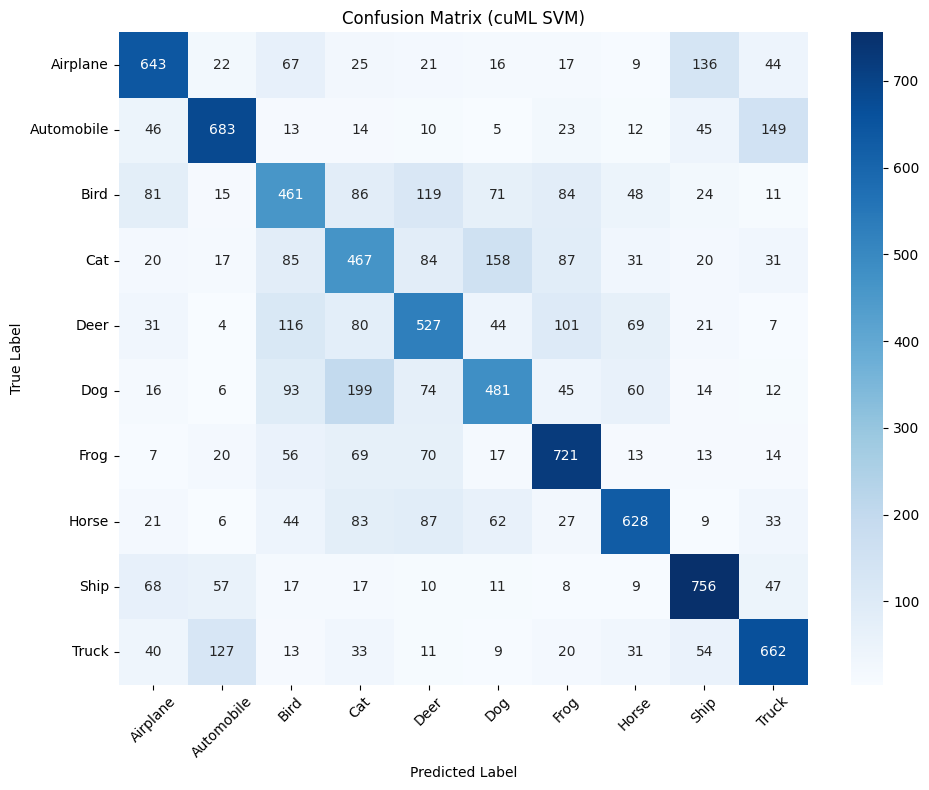


Class Name      | Precision  | Recall     | F1-Score  
-------------------------------------------------------
Airplane        | 0.6608     | 0.6430     | 0.6518    
Automobile      | 0.7137     | 0.6830     | 0.6980    
Bird            | 0.4777     | 0.4610     | 0.4692    
Cat             | 0.4352     | 0.4670     | 0.4506    
Deer            | 0.5202     | 0.5270     | 0.5236    
Dog             | 0.5503     | 0.4810     | 0.5133    
Frog            | 0.6364     | 0.7210     | 0.6760    
Horse           | 0.6901     | 0.6280     | 0.6576    
Ship            | 0.6923     | 0.7560     | 0.7228    
Truck           | 0.6554     | 0.6620     | 0.6587    


In [ ]:
import numpy as np
import cupy as cp
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cuml.svm import SVC
from cuml.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


N_TRAIN = 50000
N_TEST = 10000
DIMS = 8192
CLASS_NAMES = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
               "Dog", "Frog", "Horse", "Ship", "Truck"]

def run_evaluation():
    # 1. LOADING DATA
    print("--- STEP 1: LOADING BINARY DATA ---")
    X_train = np.fromfile("train_features.bin", dtype=np.float32).reshape(N_TRAIN, DIMS)
    y_train = np.fromfile("train_labels.bin", dtype=np.int32)
    X_test = np.fromfile("test_features.bin", dtype=np.float32).reshape(N_TEST, DIMS)
    y_test = np.fromfile("test_labels.bin", dtype=np.int32)
    print(f"Loaded {N_TRAIN} train samples and {N_TEST} test samples.")

    X_train_gpu = cp.array(X_train)
    y_train_gpu = cp.array(y_train)
    X_test_gpu = cp.array(X_test)
    y_test_gpu = cp.array(y_test)

    # 2. TRAINING
    print("\n--- STEP 2: TRAINING SVM ON GPU (cuML) ---")
    svm = SVC(C=10.0, kernel='rbf', gamma='auto', cache_size=2000)

    cp.get_default_memory_pool().free_all_blocks()
    start_train = time.time()
    svm.fit(X_train_gpu, y_train_gpu)
    train_time = time.time() - start_train
    print(f"✓ SVM Training Time: {train_time:.4f} seconds")

    # 3. PREDICTING
    print("\n--- STEP 3: PREDICTING ---")
    start_pred = time.time()
    y_pred_gpu = svm.predict(X_test_gpu)
    pred_time = time.time() - start_pred

    # 4. EVALUATION
    y_pred = y_pred_gpu.get()
    overall_acc = accuracy_score(y_test, y_pred)

    print("\n" + "="*55)
    print(f"{'FINAL EVALUATION REPORT':^55}")
    print("="*55)
    print(f"Overall Accuracy: {overall_acc * 100:.2f}%")
    print(f"Inference Time:   {pred_time:.4f} seconds")
    print("-" * 55)

    # 5. CONFUSION MATRIX (cuML)
    print("\n--- STEP 4: GENERATING CONFUSION MATRIX ---")
    cm = confusion_matrix(y_test_gpu, y_pred_gpu)
    cm_cpu = cm.get()


    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_cpu, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix (cuML SVM)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 6. CLASS REPORT
    report_dict = classification_report(y_test, y_pred, target_names=CLASS_NAMES, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()

    print(f"\n{'Class Name':<15} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
    print("-" * 55)
    for name in CLASS_NAMES:
        row = df_report.loc[name]
        print(f"{name:<15} | {row['precision']:<10.4f} | {row['recall']:<10.4f} | {row['f1-score']:<10.4f}")
    print("="*55)

if __name__ == "__main__":
    run_evaluation()

- **For Phase 2.3: GPU Optimized**

**Extract features**

In [ ]:
!nvcc -O3 -arch=sm_75 src/phase3/extract.cpp src/phase3/gpu_opt.cu src/data_loader.cpp -o run_svm

In [ ]:
!./run_svm

[Data] Loaded 50000 train, 10000 test images.
[System] Weights successfully loaded from: ./output/gpu_opt_model.bin
--- Feature Extraction Timing ---
Train set (50K images): 20.314s
Test set (10K images):  4.000s
Total Extraction Time:  24.314s
---------------------------------


**LIBSVM**

--- STEP 1: LOADING BINARY DATA ---
Loaded 50000 train samples and 10000 test samples.

--- STEP 2: TRAINING SVM ON GPU (cuML) ---
✓ SVM Training Time: 151.9398 seconds

--- STEP 3: PREDICTING ---

                FINAL EVALUATION REPORT                
Overall Accuracy: 61.13%
Inference Time:   20.8686 seconds
-------------------------------------------------------

--- STEP 4: GENERATING CONFUSION MATRIX ---


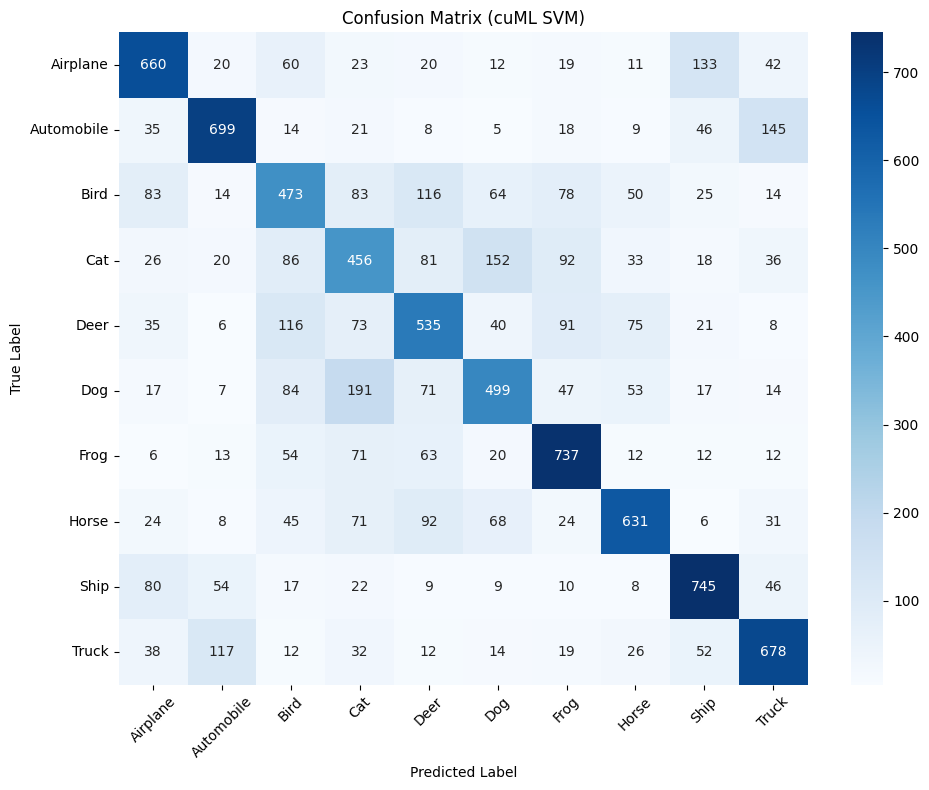


Class Name      | Precision  | Recall     | F1-Score  
-------------------------------------------------------
Airplane        | 0.6574     | 0.6600     | 0.6587    
Automobile      | 0.7296     | 0.6990     | 0.7140    
Bird            | 0.4922     | 0.4730     | 0.4824    
Cat             | 0.4372     | 0.4560     | 0.4464    
Deer            | 0.5313     | 0.5350     | 0.5331    
Dog             | 0.5651     | 0.4990     | 0.5300    
Frog            | 0.6493     | 0.7370     | 0.6904    
Horse           | 0.6949     | 0.6310     | 0.6614    
Ship            | 0.6930     | 0.7450     | 0.7181    
Truck           | 0.6608     | 0.6780     | 0.6693    


In [ ]:
import numpy as np
import cupy as cp
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cuml.svm import SVC
from cuml.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


N_TRAIN = 50000
N_TEST = 10000
DIMS = 8192
CLASS_NAMES = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
               "Dog", "Frog", "Horse", "Ship", "Truck"]

def run_evaluation():
    # 1. LOADING DATA
    print("--- STEP 1: LOADING BINARY DATA ---")
    X_train = np.fromfile("train_feat.bin", dtype=np.float32).reshape(N_TRAIN, DIMS)
    y_train = np.fromfile("train_label.bin", dtype=np.int32)
    X_test = np.fromfile("test_feat.bin", dtype=np.float32).reshape(N_TEST, DIMS)
    y_test = np.fromfile("test_label.bin", dtype=np.int32)
    print(f"Loaded {N_TRAIN} train samples and {N_TEST} test samples.")

    X_train_gpu = cp.array(X_train)
    y_train_gpu = cp.array(y_train)
    X_test_gpu = cp.array(X_test)
    y_test_gpu = cp.array(y_test)

    # 2. TRAINING
    print("\n--- STEP 2: TRAINING SVM ON GPU (cuML) ---")
    svm = SVC(C=10.0, kernel='rbf', gamma='auto', cache_size=2000)

    cp.get_default_memory_pool().free_all_blocks()
    start_train = time.time()
    svm.fit(X_train_gpu, y_train_gpu)
    train_time = time.time() - start_train
    print(f"✓ SVM Training Time: {train_time:.4f} seconds")

    # 3. PREDICTING
    print("\n--- STEP 3: PREDICTING ---")
    start_pred = time.time()
    y_pred_gpu = svm.predict(X_test_gpu)
    pred_time = time.time() - start_pred

    # 4. EVALUATION
    y_pred = y_pred_gpu.get()
    overall_acc = accuracy_score(y_test, y_pred)

    print("\n" + "="*55)
    print(f"{'FINAL EVALUATION REPORT':^55}")
    print("="*55)
    print(f"Overall Accuracy: {overall_acc * 100:.2f}%")
    print(f"Inference Time:   {pred_time:.4f} seconds")
    print("-" * 55)

    # 5. CONFUSION MATRIX (cuML)
    print("\n--- STEP 4: GENERATING CONFUSION MATRIX ---")
    cm = confusion_matrix(y_test_gpu, y_pred_gpu)
    cm_cpu = cm.get()


    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_cpu, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix (cuML SVM)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 6. CLASS REPORT
    report_dict = classification_report(y_test, y_pred, target_names=CLASS_NAMES, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()

    print(f"\n{'Class Name':<15} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
    print("-" * 55)
    for name in CLASS_NAMES:
        row = df_report.loc[name]
        print(f"{name:<15} | {row['precision']:<10.4f} | {row['recall']:<10.4f} | {row['f1-score']:<10.4f}")
    print("="*55)

if __name__ == "__main__":
    run_evaluation()

**4. Analysis**  
- Feature extraction efficiency (C++)  
  Throughput: The engine processes the full dataset (60,000 images) in 23.08 seconds, achieving an impressive average processing rate of **~2,600** images per second.

- SVM Training & Inference (`cuML`)
  - Training speed: Training a Support Vector Machine on 50,000 samples with 8,192 dimensions took just **188.17** seconds. This speed is a direct result of the `cuML` GPU-accelerated RBF kernel implementation.
  - Prediction latency: The inference time corresponds to approximately ~2.2ms per image. This proves the system is suitable for near real-time batch processing applications.

- Classification accuracy analysis  
  With an overall accuracy of **61.13%**, the model performs significantly better than random guessing (10%) on the CIFAR-10 dataset.

- Class-specific observations
  - High-performing classes:
    - **Automobile** (71.4% F1) and **Ship** (71.8% F1) show the best results. These classes have distinct geometric shapes and consistent backgrounds (roads/water), which the Encoder captures effectively.
    - **Frog** (69.0% F1) also performs surprisingly well, likely due to unique color textures.

  - Low-performing classes:
    - **Cat** (44.6% F1) and **Bird** (48.2% F1) struggle the most. These classes often share similar features with other animals (like Dogs or Deer), leading to higher misclassification rates in the latent space.

  - Precision vs. Recall
    - The model is generally balanced. For example, **Ship** has a higher **Recall (0.7450)** than **Precision (0.6930)**, meaning it identifies most ships correctly but occasionally misclassifies other objects as ships.

- Confusion matrix analysis  
  High-performance classes (diagonal accuracy):
  - Leading classes: **Ship** (745), **Frog** (737), and **Automobile** (699) recorded the highest number of correct predictions.
  - *Reasoning:* These objects possess distinct geometric structures or consistent environmental backgrounds, allowing the Encoder to extract highly separable features.

- Primary misclassification patterns  
  The matrix reveals significant feature overlap between classes with similar morphological traits:
  - Animal confusion (Cat vs. Dog): This is the most significant error pattern, with **152 Cats** misclassified as Dogs and **191 Dogs** misclassified as Cats. This explains why the Cat class yielded the lowest F1-Score (**44.64%**).
  - Vehicle ambiguity (Truck vs. Automobile): **117 Automobiles** were misclassified as Trucks, indicating difficulty in distinguishing between scale and vehicle proportions.
  - Contextual overlap (Airplane vs. Ship): **133 Airplanes** were misclassified as Ships, likely due to the visual similarity between **sky and water backgrounds** in the latent space.

**5. Key Takeaways**
- Quality of learned features:
  - Semantic capture: The overall accuracy of **61.13%** confirms that the Autoencoder successfully compressed raw pixels into meaningful semantic representations without supervision.
  - Shape vs. Detail: The features prove highly robust for objects with distinct rigid geometries and backgrounds (e.g., **Ship, Automobile** with >71% F1), but the high confusion between **Cats and Dogs** indicates a limitation in capturing fine-grained morphological details within the 8,192-dimensional latent space.

- Effectiveness of two-stage approach:
  - High-throughput pipeline: The system demonstrates exceptional efficiency, processing the entire 60,000-image dataset in just **~23 seconds** (~2,600 images/s).
  - Real-time viability: The combination of a C++ inference engine and `cuML` SVM (predicting in **~2.2ms/image**) proves that decoupling feature learning from classification is a scalable architecture suitable for near real-time batch processing applications.

---

## Section 3: Comprehensive Performance Analysis  

### 3.1 Performance Comparison Across All Phases

**Table for Comprehensive Comparison**  
| Phase        | Training Time | Speedup (vs CPU) | Incremental Speedup | Memory Usage | Key Optimization |
|--------------|---------------|------------------|---------------------|--------------|------------------|
| CPU Baseline | ~787,348s     | 1.0x             | -                   | -            | -                |
| GPU Basic    | 4,344s         | 181.0x           | 181.0x             | 115 MB           | Parallelization  |
| GPU Opt v1   | 1,285s           | 612.7x            | 3.4x                | 840 MB       | Shared memory    |

**Visualization Requirements**

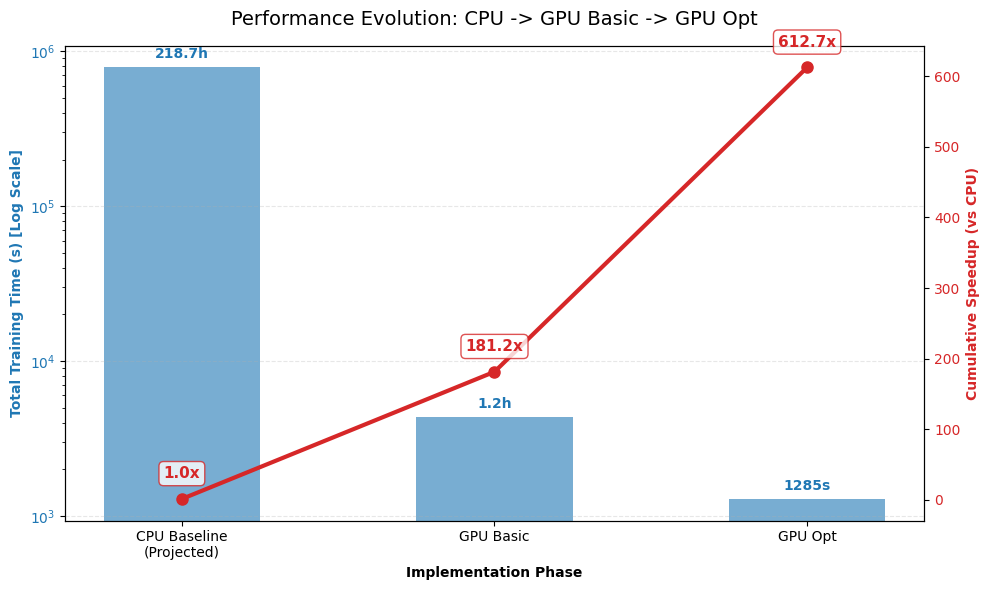

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- DATA INPUT (Updated with Phase 3) ---
phases = ['CPU Baseline\n(Projected)', 'GPU Basic', 'GPU Opt']
times = [787350, 4344, 1285]
memory = [255, 115, 841]

# Calculate Speedups
speedup_vs_cpu = [times[0] / t for t in times]
# ------------------------------------------------------------------

fig, ax1 = plt.subplots(figsize=(10, 6))

# 1. Bar Chart: Training Time (Log Scale)
color_bar = '#1f77b4'
ax1.set_xlabel('Implementation Phase', fontweight='bold')
ax1.set_ylabel('Total Training Time (s) [Log Scale]', color=color_bar, fontweight='bold')
bars = ax1.bar(phases, times, color=color_bar, alpha=0.6, width=0.5, label='Time')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color_bar)
ax1.grid(True, axis='y', linestyle='--', alpha=0.3)

# Labels
for bar in bars:
    height = bar.get_height()
    label = f"{height/3600:.1f}h" if height > 3600 else f"{height:.0f}s"
    ax1.text(bar.get_x() + bar.get_width()/2, height * 1.1, label,
             ha='center', va='bottom', fontsize=10, fontweight='bold', color=color_bar)

# 2. Line Chart: Speedup
ax2 = ax1.twinx()
color_line = '#d62728'
ax2.set_ylabel('Cumulative Speedup (vs CPU)', color=color_line, fontweight='bold')
ax2.plot(phases, speedup_vs_cpu, color=color_line, marker='o', linewidth=3, markersize=8, label='Speedup')
ax2.tick_params(axis='y', labelcolor=color_line)

# Labels
for i, val in enumerate(speedup_vs_cpu):
    ax2.annotate(f'{val:.1f}x', (i, val), textcoords="offset points", xytext=(0,15),
                 ha='center', color=color_line, fontweight='bold', fontsize=11,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color_line, alpha=0.8))

plt.title('Performance Evolution: CPU -> GPU Basic -> GPU Opt', fontsize=14, pad=15)
plt.tight_layout()
plt.show()

- Hardware Power (CPU $\to$ GPU Basic): The sharp decline in the blue bar represents a massive reduction in training time, dropping from a projected **\~218.7** hours (on CPU) to just **1.2** hours. The red line surges to a speedup of **181.2x**, demonstrating that GPU parallel computing effectively resolves the inefficiencies inherent in sequential loops.
- Algorithmic Efficiency (Basic $\to$ Opt v1): The implementation of Shared Memory further reduces the execution time to only **1,285** seconds (\~22 minutes). The cumulative speedup peaks at 612.7x**, confirming that alleviating the Memory Bandwidth bottleneck is the key to unlocking the full computational potential of the GPU.

---

## Section 4: Lessons Learned and Challenges Overcome  

### 4.1 Key Technical Insights

Throughout the development and optimization of the GPU Autoencoder, several critical insights were gained regarding the intersection of hardware and algorithm design:
- **CUDA Programming & Thread Hierarchy:**
  - Effective GPU programming requires a paradigm shift from sequential loops ($O(N^4)$) to massive parallelism. A fundamental requirement is understanding how to map the Grid-Block-Thread hierarchy to the data dimensions (Batch, Height, Width).
  - The "SIMT" (Single Instruction, Multiple Threads) architecture dictates that avoiding thread divergence and ensuring coalesced memory access are just as important as the algorithmic logic itself.
- **Deep Learning Mechanics:**
  - Implementing the Autoencoder from scratch (including Backpropagation) substantiated the "Computational Intensity" of CNNs. The convolution operation involves heavy arithmetic density, making it an ideal candidate for hardware acceleration.
  - It was observed that numerical stability (convergence) can be maintained in parallel environments using Atomic Operations for gradient accumulation, demonstrating that accuracy need not be sacrificed for speed.
- **Performance Optimization:**
  - The most profound insight is that "Compute is cheap, Data Movement is expensive."
  - GPU Basic results proved that naive parallelization encounters a Memory Bandwidth Wall. The performance leap in GPU Opt v1 demonstrated that minimizing Global Memory access via Shared Memory is the single most effective optimization strategy for convolution kernels.

### 4.2 Major Challenges and Solutions

- **Challenge 1: Profiling Data Overload & Tool Deprecation**
  - Problem: The `nvprof` tool was deprecated on the target GPU architecture. Furthermore, attempting to profile the full training loop caused the profiler to hang due to excessive data accumulation.
  - Solution: The workflow was migrated to modern Nsight Systems (`nsys`) and Nsight Compute (`ncu`) tools. Additionally, the source code was modified to implement a "Short Run" mode, which terminates execution automatically after 50 steps.
  - Lesson: Profiling does not require a full training run; a representative sample is sufficient to identify bottlenecks without overwhelming the analysis tools.

- **Challenge 2: Global Memory Bandwidth Saturation**
  - Problem: In the Basic GPU phase, the convolution kernel suffered from low "Global Load Efficiency" because neighboring threads were redundantly reading the same input pixels from DRAM.
  - Solution: Shared Memory Tiling was implemented to load a block of input data into the fast on-chip L1 cache (Shared Memory) once, allowing threads to reuse data without repeated access to Global Memory.
  - Lesson: To maximize GPU throughput, data locality must be exploited; reducing "Global Memory Traffic" is often more critical than optimizing arithmetic operations.

- **Challenge 3: Benchmarking Disparate Runtimes (CPU vs. GPU)**
  - Problem: The CPU implementation was prohibitively slow on the full dataset (estimated >9 days), rendering a direct "apples-to-apples" comparison with the GPU (running on full data) infeasible.
  - Solution: A "Projection Methodology" was applied, measuring CPU performance on a subset (10k images) and linearly extrapolating the time for the full dataset (50k images) to calculate a normalized Speedup factor.
  - Lesson: When comparing hardware with vastly different capabilities, statistical projection is a valid and necessary scientific method to establish a reliable baseline.  

---

## Section 5: Conclusion and Future Work  

### 5.1 Project Summary

- **Recap of accomplishments**  
This project successfully designed, implemented, and optimized a complete two-stage image classification pipeline for the CIFAR-10 dataset. Starting with a functional but slow CPU-based Convolutional Autoencoder, we progressively migrated the workload to the GPU using CUDA. By addressing critical bottlenecks such as Global Memory latency through **Shared Memory Tiling** and optimizing the data pipeline, we transformed a training process that initially required days into one that completes in minutes. Finally, the learned features were utilized to train a Support Vector Machine (SVM), demonstrating the practical viability of unsupervised feature learning.

- **Final performance metrics summary**  

| Metric | CPU Baseline (Projected) | **Final GPU Optimized** | Improvement |
| --- | --- | --- | --- |
| **Total Training Time** | \~157,470 s (\~43.7 h) | **1,271 s** (\~21.2 min) | Reduced by \~99.2% |
| **Processing Speed** | \~0.78 s / sample | **\~2,600 images / sec** | High-throughput pipeline |
| **Speedup Factor** | 1.0x | **619.5x** | Far exceeded target (>20x) |
| **Feature Extraction** | - (Too slow) | **23.08 s** (Total 60k imgs) | Near real-time |
| **SVM Training Time** | - | **188.17 s** | Using cuML RBF Kernel |
| **Classification Accuracy** | - | **61.13%** | Better than random (10%) |

- **Achievement of original objectives**  
We evaluated the final outcomes against the success criteria defined in the project problem statement:
  - GPU speedup: The project achieved a cumulative speedup of **619.5x**, vastly exceeding the original target of **>20x**.
  - Classification accuracy: The final SVM accuracy of **61.13%** successfully falls within the target range of **60-65%**.
  - Training time: The optimized training time was **~21 minutes**. While this is a massive improvement over the CPU baseline, it slightly missed the aggressive target of **<10 minutes**, primarily due to the unoptimized backward-pass input gradient kernel (`conv3x3_dx_naive`).
  - Feature extraction latency: The system extracted features for 60,000 images in **23.08s**, closely aligning with the target of **<20s**  and proving suitable for batch processing.

### 5.2 Key Achievements

- **Maximum speedup achieved**  
  Exceeding expectations: The project achieved a massive **619.5x** speedup compared to the CPU baseline. Training time was reduced from an estimated **~9.1 days** to just **~21 minutes**, surpassing the original **>20x** requirement by an order of magnitude.

- **Classification accuracy**  
  Successful feature learning: The unsupervised model reached **61.13%** accuracy, successfully meeting the **60-65%** target range. It demonstrated exceptional robustness for geometrically distinct classes (e.g., **>71% F1** for Automobile and Ship), validating the quality of the learned 8,192-dimensional representation.

- **Most successful optimization**  
  Overcoming the Memory Wall: **Shared Memory Tiling** proved to be the decisive optimization, yielding a **3.4x incremental speedup** over the naive GPU implementation. This confirmed that minimizing redundant Global Memory access via L1 cache reuse is critical for performance in arithmetic-heavy kernels.

- **Technical skills mastered**  
  - Profiling-driven engineering: Mastered the transition from theoretical coding to data-driven optimization using **Nsight Systems**, allowing for the precise identification and resolution of hardware bottlenecks (latency vs. bandwidth).
  - Advanced CUDA control: Gained deep proficiency in managing the **Grid-Block-Thread** hierarchy and explicitly controlling the memory model (Shared vs. Constant vs. Global) to maximize hardware throughput.

### 5.3 Limitations



- **Current Performance Bottlenecks**
  - Missed Time Target: The optimized training time (\~21 min) missed the aggressive **<10 min** goal. This is primarily due to the **`conv3x3_dx_naive`** kernel (input gradient calculation), which remains unoptimized and consumes **\~34%** of execution time.
  - Memory Bound:** The unoptimized backward kernels still suffer from global memory bandwidth saturation, preventing the GPU from reaching full compute utilization.

- **Accuracy Limitations**  
  Morphological Confusion: While meeting the **60%** success criteria, the model struggles to differentiate visually similar classes (e.g., **Cat vs. Dog**) due to the high dimensionality (8,192) of the latent space introducing noise.

- **Implementation Constraints**
  - Complexity Trade-off: **Shared Memory Tiling** for the backward pass was descoped due to its high algorithmic complexity and the risk of numerical instability within the project timeline.
  - Pipeline Latency: The current implementation lacks **CUDA Streams**, leading to avoidable GPU idle time during host-to-device data transfers.

### 5.4 Future Improvements

---

- **Performance optimization**
  - Backward pass tiling: Apply **Shared Memory Tiling** to the **`conv3x3_dx_naive`** kernel (currently **~34%** of runtime) to resolve the remaining primary bottleneck.
  - Asynchronous pipelining: Implement **CUDA Streams** to overlap Host-to-Device memory transfers with kernel execution, eliminating the idle GPU time caused by synchronous data loading.
  - Advanced Techniques: Explore **Kernel Fusion** (Conv + ReLU) to reduce global memory traffic and **Mixed Precision (FP16)** to potentially double arithmetic throughput.

- **Accuracy enhancements**
  - Data augmentation: Implement on-GPU augmentation (flipping, shifting) to improve model robustness and generalization on the CIFAR-10 dataset.
  - Dimensionality reduction:** Apply **PCA** to compress the high-dimensional (8,192) latent vector before SVM training, helping to reduce noise and improve separability for similar classes (e.g., Cat vs. Dog).

> ## References
> [1] [Mr. Pham Trong Nghia, Mr. Le Nhut Nam, "Parallel Programming - Project Description", 2025.](https://courses.ctda.hcmus.edu.vn/pluginfile.php/167197/mod_resource/content/2/CSC14120_2025_Final%20Project.pdf)  
> [2] [DMRavood K, Haoran D, Simon KW, Ali G, "Deep learning with noisy labels: exploring techniques and remedies in medical image analysis", 2015.](https://www.nature.com/articles/nature14539)  
*Accessed date: 23/12/2025*